**라이브러리 로드**

In [1]:
import torch
print("torch.cuda.is_available() =", torch.cuda.is_available())
print("torch.cuda.device_count() =", torch.cuda.device_count())
print("torch.version.cuda =", torch.version.cuda)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

torch.cuda.is_available() = True
torch.cuda.device_count() = 1
torch.version.cuda = 12.6


***라이브러리 설치 - RoboFlow***

In [2]:
!pip install roboflow ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 143.7 MB/s eta 0:00:00


**YOLO Fine-tuning**

In [3]:
# ==========================================
# Roboflow 데이터 다운로드
# ==========================================

from roboflow import Roboflow
rf = Roboflow(api_key="     ")
project = rf.workspace("yunhoo93").project("09-yezue-4s43q")
dataset = project.version(5).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 09-5 in yolov8:: 100%|██████████| 45833/45833 [00:24<00:00, 1851.91it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Object Dectection**

In [38]:
from ultralytics import YOLO
from roboflow import Roboflow
import matplotlib.pyplot as plt
import os, random

# -------------------------------------------
# 1. Roboflow 데이터셋 로드
# -------------------------------------------
train_img_dir = os.path.join(dataset.location, "train", "images")
valid_img_dir = os.path.join(dataset.location, "valid", "images")
test_img_dir  = os.path.join(dataset.location, "test", "images")

train_lbl_dir = os.path.join(dataset.location, "train", "labels")
valid_lbl_dir = os.path.join(dataset.location, "valid", "labels")
test_lbl_dir  = os.path.join(dataset.location, "test", "labels")

# -------------------------------------------
# 2. 클래스별 이미지 하나씩 선택 (랜덤 버전)
# -------------------------------------------
def get_one_image_per_class(image_dir, label_dir, max_count=4):
    class_to_imgs = {}    # 클래스별 이미지 list 저장

    for lbl in os.listdir(label_dir):
        if not lbl.endswith(".txt"):
            continue

        label_path = os.path.join(label_dir, lbl)
        with open(label_path, "r") as f:
            line = f.readline().strip()

        if not line:
            continue

        cls_id = int(line.split()[0])

        img_name = lbl.replace(".txt", ".jpg")
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            if cls_id not in class_to_imgs:
                class_to_imgs[cls_id] = []
            class_to_imgs[cls_id].append(img_path)

    # ✅ 클래스별 랜덤 1장 선택
    selected = {}
    for cls_id in sorted(class_to_imgs.keys()):
        if len(selected) >= max_count:
            break
        selected[cls_id] = random.choice(class_to_imgs[cls_id])

    return selected


# -------------------------------------------
# 3. 시각화 함수 (4개 클래스 다른 이미지)
# -------------------------------------------
def show_by_class(image_dir, label_dir, title):
    cls_imgs = get_one_image_per_class(image_dir, label_dir, max_count=4)
    class_ids = sorted(cls_imgs.keys())

    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=18)

    for idx, cls_id in enumerate(class_ids, 1):
        img_path = cls_imgs[cls_id]

        results = model(img_path)[0]
        plotted = results.plot()

        plt.subplot(2, 2, idx)
        plt.imshow(plotted)
        plt.title(f"Case {cls_id+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# -------------------------------------------
# 4. best.pt 성능 출력
# -------------------------------------------
def evaluate_split(split_name):
    if split_name == "valid":
        split_name = "val"

    print(f"\n===== {split_name.upper()} EVALUATION =====")

    data_yaml = os.path.join(dataset.location, "data.yaml")

    metrics = model.val(
        data=data_yaml,
        split=split_name,
        imgsz=640,
        save=False
    )

    precision = float(metrics.box.mp)
    recall    = float(metrics.box.mr)
    map50     = float(metrics.box.map50)
    map50_95  = float(metrics.box.map)

    print(f"{split_name} Precision: {precision:.4f}")
    print(f"{split_name} Recall:    {recall:.4f}")
    print(f"{split_name} mAP50:     {map50:.4f}")
    print(f"{split_name} mAP50-95:  {map50_95:.4f}")

In [39]:
# -------------------------------------------
# 5. YOLO 모델 로드
# -------------------------------------------

model = YOLO("best110.pt")

In [ ]:
# -------------------------------------------
# 6. Train / Valid / Test 평가
# -------------------------------------------

evaluate_split("train")
evaluate_split("val")
evaluate_split("test")


image 1/1 /content/09-5/test/images/310_jpg.rf.5e6255623f4b70d90d47d2b501817e78.jpg: 1024x1024 3 damage_roads, 19.0ms
Speed: 8.0ms preprocess, 19.0ms inference, 1.7ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/Screenshot-2025-01-23-045512_png.rf.d55dd063012d868ec2aed64e3c610d06.jpg: 1024x1024 2 illegal_parkings, 17.4ms
Speed: 7.1ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/702_20_ab63e632-68aa-4640-9275-7332863fff7c_jpeg.rf.94d98d33c0a067b2728f868a3909cda1.jpg: 1024x1024 1 safety_fence, 17.4ms
Speed: 7.0ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/images-44-_jpeg.rf.ecd99d11a215826f933081a744d9e96d.jpg: 1024x1024 1 street_light, 17.4ms
Speed: 7.0ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


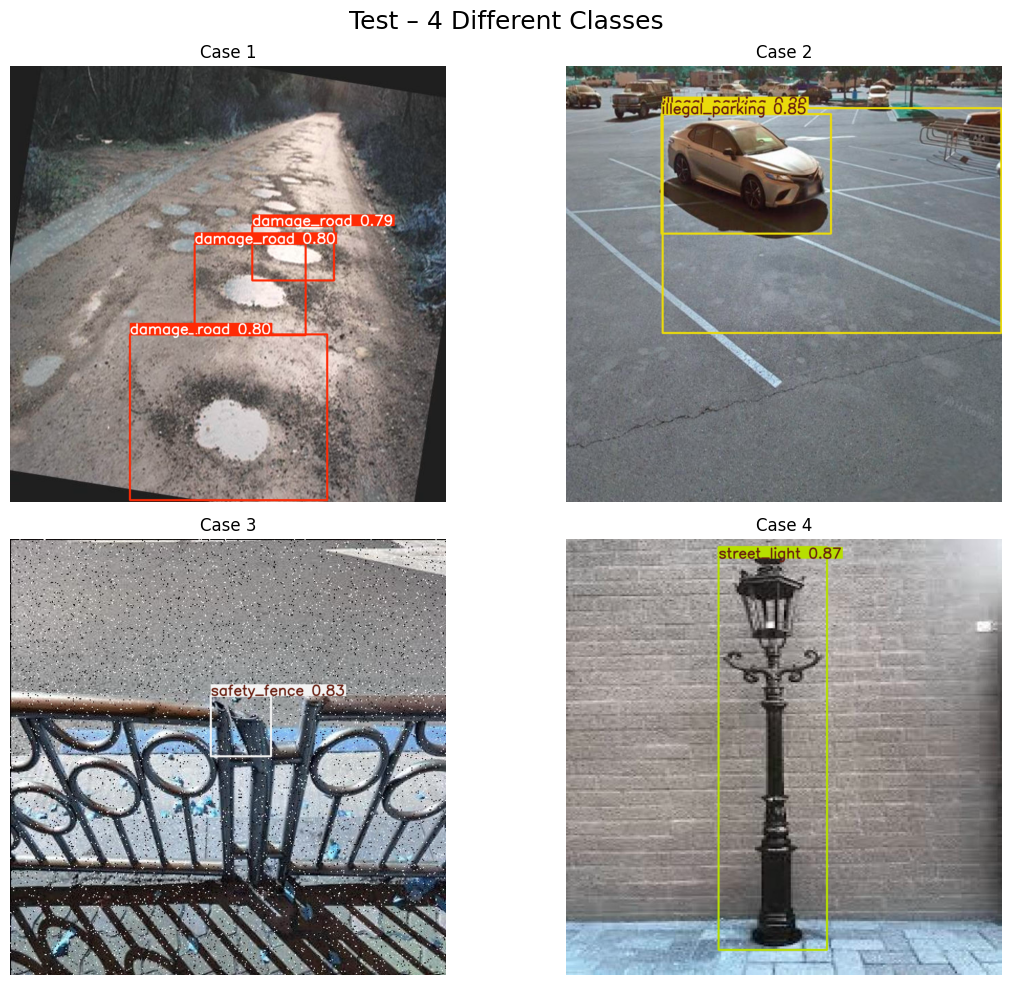


image 1/1 /content/09-5/test/images/491_jpg.rf.1d64c76f2c810f8d76ea90acf2fad027.jpg: 1024x1024 2 damage_roads, 17.5ms
Speed: 7.4ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/1801678725_f32e7d72ed_c_jpg.rf.2c8037d7a6fcf685b45c82b3fbeed359.jpg: 1024x1024 1 illegal_parking, 18.9ms
Speed: 7.2ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/702_20_b2bcd5c1-c708-40ba-9070-623f526bf898_jpeg.rf.1d3c0b5c2a9ee39bad0bab0688a8297d.jpg: 1024x1024 1 safety_fence, 17.8ms
Speed: 7.1ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/images-53-_jpeg.rf.1f4c919e8ccd21d1639ef8af5f4530a5.jpg: 1024x1024 (no detections), 17.6ms
Speed: 7.1ms preprocess, 17.6ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


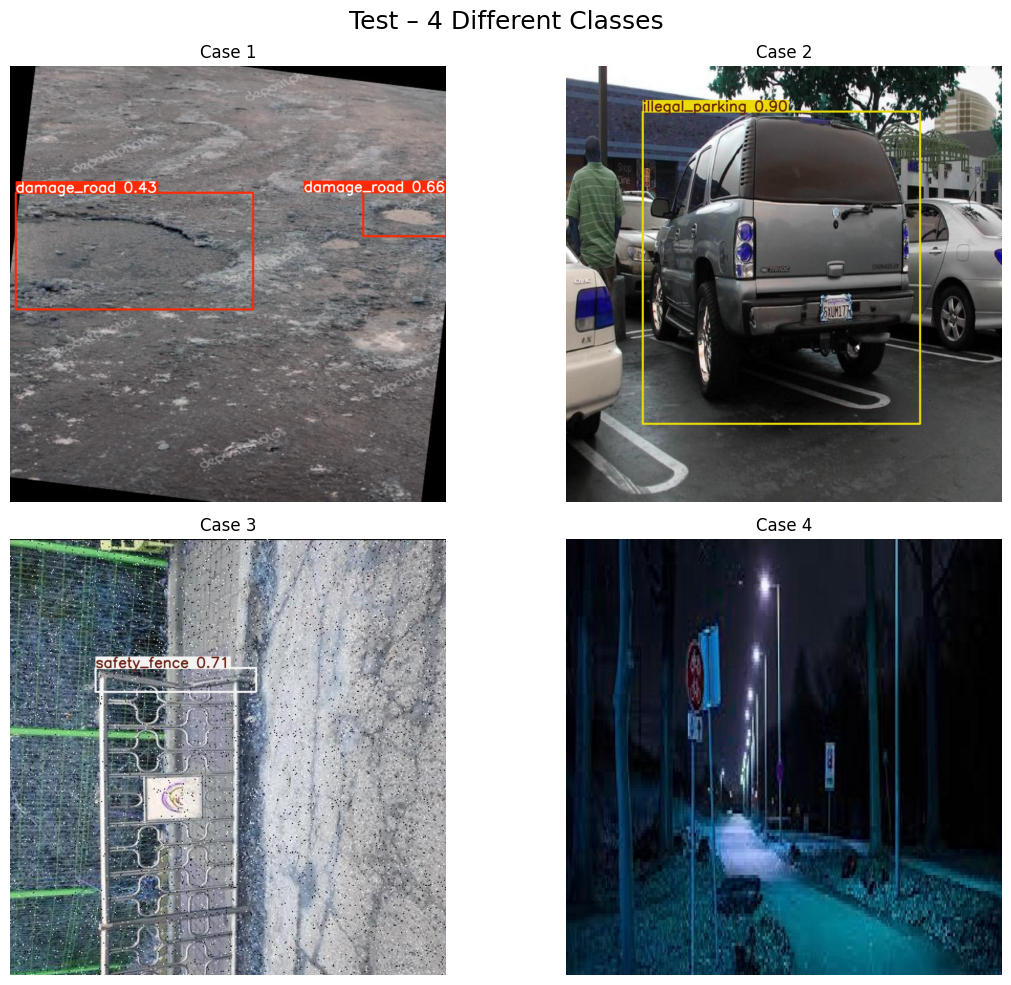


image 1/1 /content/09-5/test/images/393_jpg.rf.03df0bf2b9c92994eeffe68a9d91c08a.jpg: 1024x1024 1 damage_road, 17.8ms
Speed: 7.3ms preprocess, 17.8ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/51620371083_e8d0595096_c_jpg.rf.65dca56530352b7e4ff5da247973067c.jpg: 1024x1024 1 illegal_parking, 17.8ms
Speed: 7.1ms preprocess, 17.8ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/702_20_51a31015-bad2-4fd6-ae24-e78839c65cf2_jpeg.rf.03ddaafa94b11c739fe069c06fb64255.jpg: 1024x1024 1 safety_fence, 17.6ms
Speed: 7.2ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/23_jpg.rf.13ae9491d1909c169cbe0052d505e547.jpg: 1024x1024 2 street_lights, 17.5ms
Speed: 7.0ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)


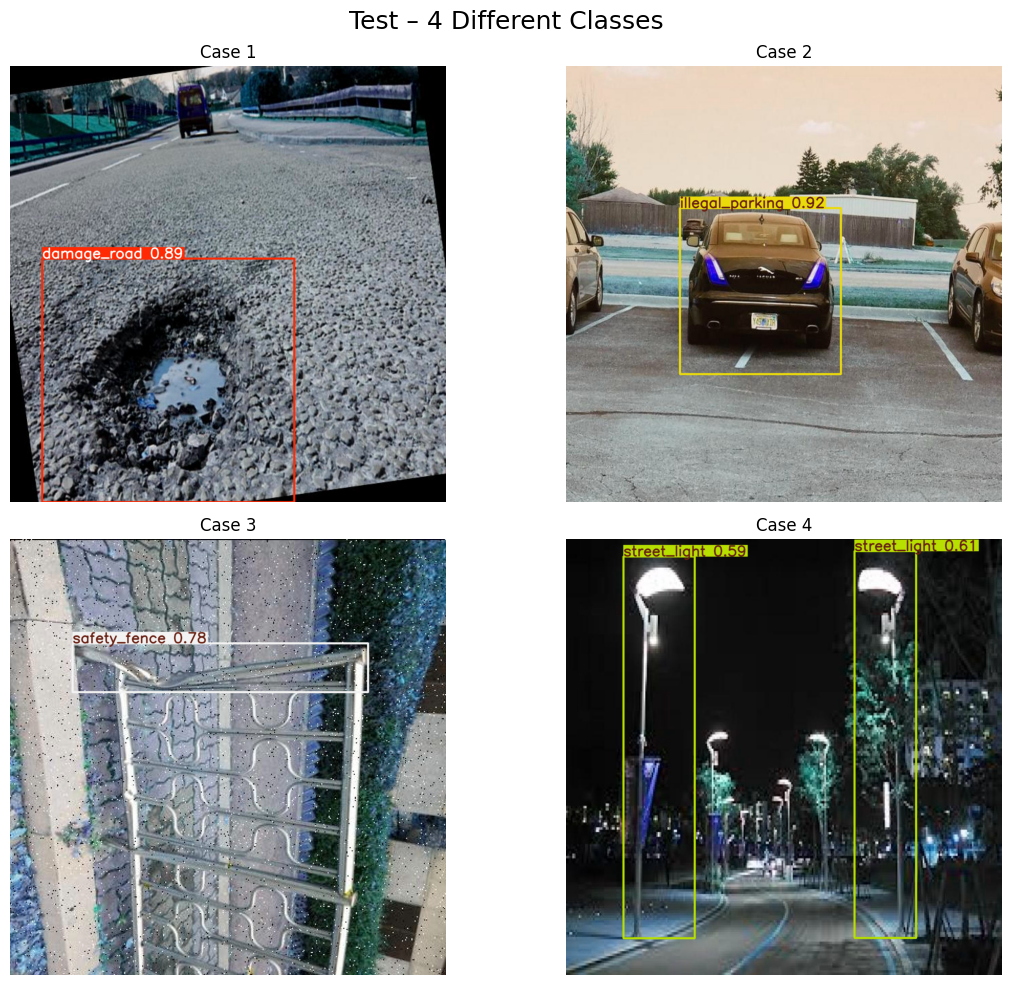


image 1/1 /content/09-5/test/images/226_jpg.rf.e301158bed7129139b335c8e0ce602ae.jpg: 1024x1024 3 damage_roads, 17.5ms
Speed: 7.3ms preprocess, 17.5ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/117214545_296778d783_c_jpg.rf.c1e283dd6b5716accc20c488ae4f624c.jpg: 1024x1024 1 illegal_parking, 17.4ms
Speed: 7.3ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/702_20_aae89ab5-8c23-4f3c-9197-06c3c4200484_jpeg.rf.fe57134d7dc9aef2c0c5a762d24d3c7f.jpg: 1024x1024 1 safety_fence, 17.6ms
Speed: 7.1ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/S__5759059_0_jpg.rf.1a39011012ea907f19a02588ebdb2312.jpg: 1024x1024 2 street_lights, 17.7ms
Speed: 7.4ms preprocess, 17.7ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)


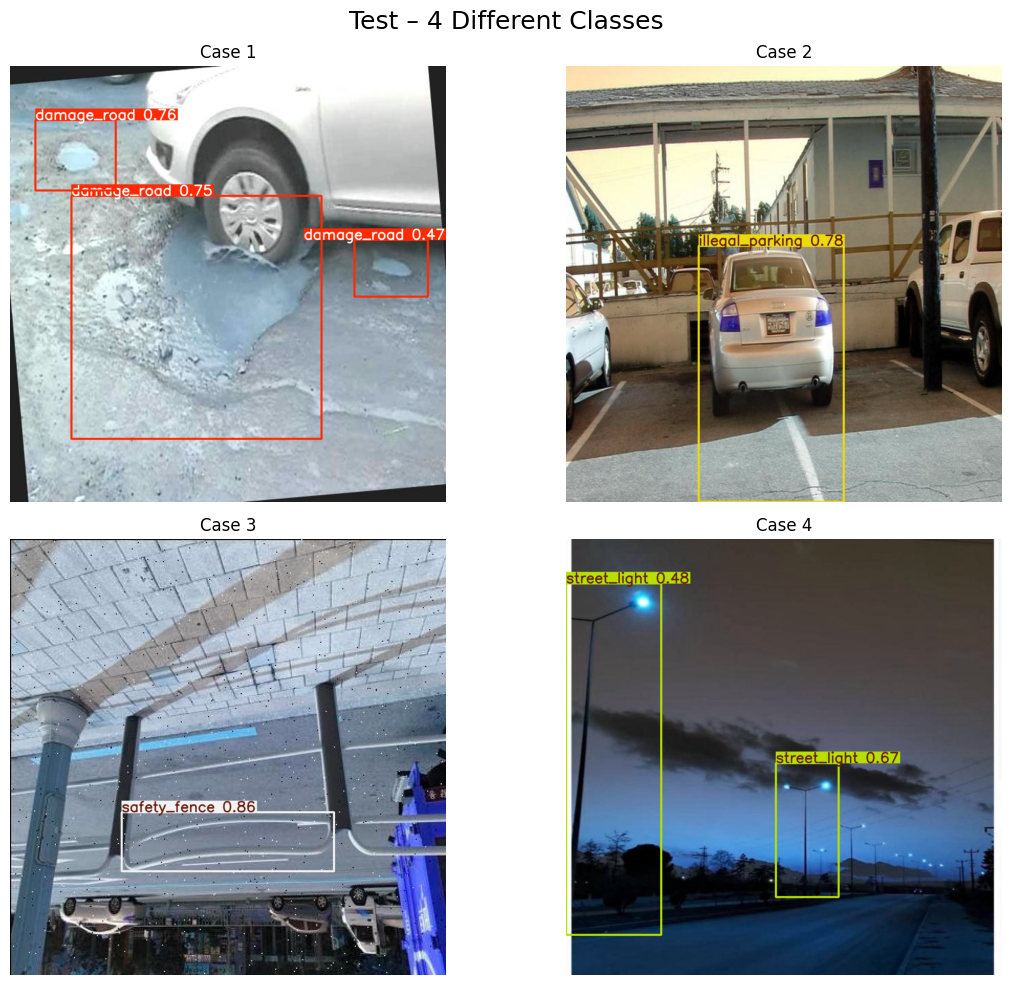


image 1/1 /content/09-5/test/images/491_jpg.rf.1d64c76f2c810f8d76ea90acf2fad027.jpg: 1024x1024 2 damage_roads, 17.7ms
Speed: 7.4ms preprocess, 17.7ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/they-took-the-extra-time-to-backup-badly-v0-l54i8mgrtrme1_webp.rf.d34bea0b1f0d38c83acbdccca2f51aff.jpg: 1024x1024 2 illegal_parkings, 19.1ms
Speed: 7.4ms preprocess, 19.1ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/702_20_22611a24-e57c-4487-a8e4-f9630710a7db_jpeg.rf.5a53558bc07b4c72613cf7e76842fe1c.jpg: 1024x1024 1 safety_fence, 18.9ms
Speed: 7.9ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/09-5/test/images/images-46-_jpeg.rf.a551b07ff9a5ee2051914ced4b1146f2.jpg: 1024x1024 (no detections), 17.4ms
Speed: 7.2ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 1024, 1024)


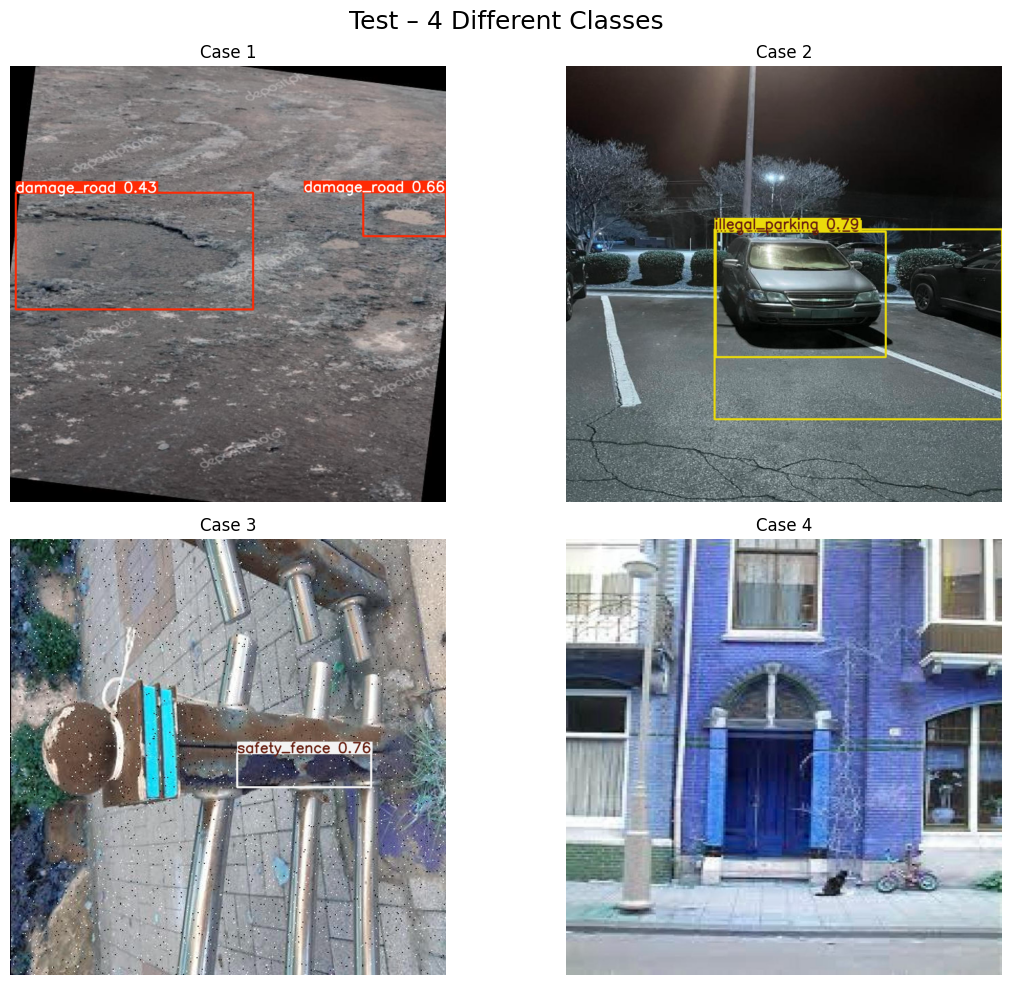

In [50]:
# -------------------------------------------
# 7. Train / Valid / Test 시각화
# -------------------------------------------

# show_by_class(train_img_dir, train_lbl_dir, "Train – 4 Different Classes")
# show_by_class(valid_img_dir, valid_lbl_dir, "Valid – 4 Different Classes")
show_by_class(test_img_dir,  test_lbl_dir,  "Test – 4 Different Classes")